In [1]:
import numpy as np
import h5py

In [279]:
hf = h5py.File('data/channel_x1_256_y1_512_z1_256_step4.h5', 'r')

In [280]:
hf.keys()

<KeysViewHDF5 ['Velocity_0001', 'xcoor', 'ycoor', 'zcoor']>

In [281]:
vels = hf.get('Velocity_0001')
xs = hf.get('xcoor')
ys = hf.get('ycoor')
zs = hf.get('zcoor')

In [282]:
np.array(ys) 

array([-1.        , -0.99896646, -0.9954647 , -0.98954684, -0.98122734,
       -0.97052634, -0.9574698 , -0.94208944, -0.9244226 , -0.9045121 ,
       -0.88240635, -0.85815895, -0.8318287 , -0.80347955, -0.77318037,
       -0.7410046 , -0.7070304 , -0.67134017, -0.63402057, -0.59516215,
       -0.5548593 , -0.5132097 , -0.47031456, -0.42627794, -0.38120672,
       -0.33521026, -0.28840026, -0.24089028, -0.19279565, -0.1442331 ,
       -0.09532048, -0.04617652,  0.00307952,  0.05232809,  0.10144965,
        0.15032499,  0.19883548,  0.24686338,  0.29429215,  0.34100664,
        0.38689348,  0.4318413 ,  0.47574106,  0.51848614,  0.5599728 ,
        0.60010046,  0.6387716 ,  0.67589235,  0.71137273,  0.7451266 ,
        0.77707195,  0.8071313 ,  0.8352317 ,  0.861305  ,  0.8852878 ,
        0.907122  ,  0.9267546 ,  0.9441379 ,  0.95922965,  0.9719934 ,
        0.982398  ,  0.99041826,  0.99603474,  0.9992338 ], dtype=float32)

In [283]:
ys = ys[1:]
vels = vels[:, 1:, :, :]

In [284]:
us = vels[..., 0]
vs = vels[..., 1]
ws = vels[..., 2]

In [285]:
slice_us_yzplane = us[0, :, :]

In [286]:
import matplotlib.pyplot as plt

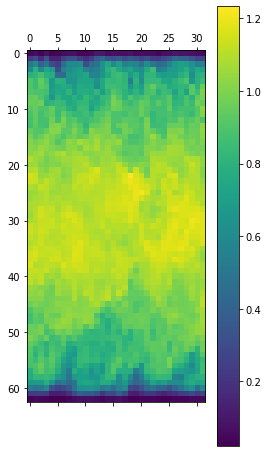

In [287]:
plt.matshow(slice_us_yzplane)
plt.colorbar()

In [288]:
# xv, yv, zv = np.meshgrid(xs, ys, zs) #, indexing="xy")
yv, xv, zv = np.meshgrid(ys, xs, zs) 

In [289]:
xv_flattened = np.expand_dims(xv.flatten(), axis=1)
yv_flattened = np.expand_dims(yv.flatten(), axis=1)
zv_flattened = np.expand_dims(zv.flatten(), axis=1)

In [290]:
coords_flattened = np.concatenate((yv_flattened, xv_flattened, zv_flattened), axis=1)
us_flattened = us.flatten()

In [291]:
xv_flattened_2d = np.expand_dims(xv[:,:,0].flatten(), axis=1)
yv_flattened_2d = np.expand_dims(yv[:,:,0].flatten(), axis=1)

In [292]:
coords_flattened_2d = np.concatenate((yv_flattened_2d, xv_flattened_2d), axis=1)

In [293]:
us2d = us[:, :, 0]
us2d_flattened = np.expand_dims(us2d.flatten(), axis=1)

In [294]:
from scipy.interpolate import griddata

In [295]:
grid_x = np.linspace(xv.min(), xv.max(), 256)
grid_y = np.linspace(yv.min(), yv.max(), 256)
grid_z = np.linspace(zv.min(), zv.max(), 256)

In [296]:
# xeval, yeval = np.meshgrid(grid_x, grid_y)
yeval, xeval = np.meshgrid(grid_y, grid_x)

In [297]:
xeval_flattened = np.expand_dims(xeval.flatten(), axis=1)
yeval_flattened = np.expand_dims(yeval.flatten(), axis=1)

In [298]:
us_interp = griddata(coords_flattened_2d, us2d_flattened, (yeval, xeval), method='linear', fill_value=0)

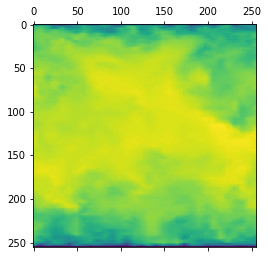

In [299]:
plt.matshow(us_interp.squeeze().T)

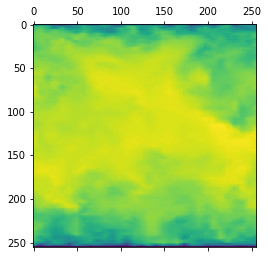

In [278]:
plt.matshow(us_interp.squeeze().T)

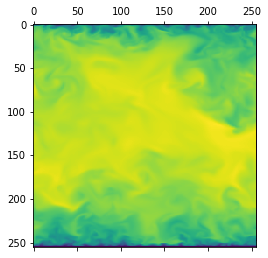

In [257]:
plt.matshow(us_interp.squeeze().T)

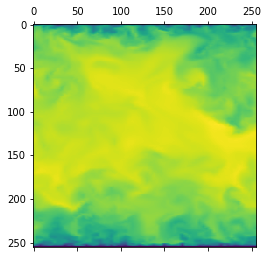

In [236]:
plt.matshow(us_interp.squeeze().T)

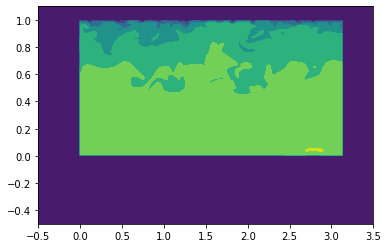

In [207]:
plt.tricontourf(xeval.flatten(), yeval.flatten(), us_interp.flatten())